# Classificação - EDA - Part. 1

Neste notebook faremos a EDA Parte 1.

## Análise de sentimento com SVM, FCC e LSTM.

## Introdução


### Definição do problema

Criar um modelo de machine learning para previsão de sentimento em comentários do twiiter.


### Verificação dos dados

Dados públicos disponíveis no [kaggle]().

Conforme [documentação]() possue as seguintes dimensões, e foram capturados do tweeter.

Descrição dos dados conforme [fonte]():

### Observação dos dados

Conforme [documentação]() temos 4 sentimentos associados às respectivas mensagens.

Ainda, pode existir (será confirmado na exploração dos dados) um desbalanceamento entre as frequêcias das classes.

https://www.kaggle.com/datasets/atifaliak/youtube-comments-dataset

## Projeto


### Bibliotecas


In [ ]:
## Definindo nível de warning
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# instalando pipline de detecção de linguagem
!pip install -q spacy-language-detection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 18.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#imports
import warnings
warnings.filterwarnings('ignore')

## data exploration/visuaization stack
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

##
import kagglehub
import shutil



## EDA e pré-processamento
import spacy
import nltk
from nltk import word_tokenize
from nltk.text import sent_tokenize
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from spacy.language import Language
from spacy_language_detection import LanguageDetector



In [ ]:
# Download do dicionário spacy
!python -m spacy download en_core_web_md -q
dicionario = spacy.load('en_core_web_md')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 35.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Baixando piplines nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('universal_tagset')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# capturando stopwords únicas do pacote nltk
stop = set(nltk.corpus.stopwords.words('english'))

### Funções

In [ ]:
# Classe para limpeza de texto - depois de limpar o texto, será criado o corpus (objeto contendo toda as palavras)
def ProcessaTexto(text) -> str:
  """
    Realiza a limpeza e normalização de um texto, aplicando remoção de ruído,
    tratamento com expressões regulares e lematização via spaCy.

    Essa função é utilizada como etapa de pré-processamento antes da criação
    do *corpus*—conjunto de palavras limpas que servirá de entrada para análises,
    modelos estatísticos ou algoritmos de NLP.

    Etapas aplicadas:
    1. Remoção de URLs.
    2. Remoção de menções (ex: @usuario).
    3. Remoção de caracteres não ASCII.
    4. Remoção de pontuação.
    5. Processamento via pipeline spaCy.
    6. Lematização e remoção de stopwords.

    Parâmetros
    ----------
    text : str
        Texto bruto a ser limpo e normalizado.

    Retorno
    -------
    str
        Texto processado contendo apenas lemas (lemmas) em minúsculas,
        sem stopwords, pontuações, URLs ou caracteres especiais.

    Observações
    -----------
    - A função depende de um objeto spaCy previamente carregado (ex.: `dicionario = nlp`).
    - As expressões regulares removem padrões comuns de redes sociais.
    - O resultado final é adequado para criação de corpus, vetorização e análise textual.
  """

  # eliminando referências à URLs
  text = re.sub(r"http\S+|www\S+|https\S+", "", text)

  # elimando menções
  text = re.sub(r"\@\w+\|\#\w\+", "", text)

  #Removendo caracteres não ASCII (não romanos)
  text = re.sub(r"[^\x00-\x7F]+", "", text)

  #Tratando Pontuação
  text = text.translate(str.maketrans("", "", string.punctuation)) # não substitui nada, apenas remove as pontuações
  # mktrans cria a tabela
  # translate faz a "tradução"

  # Aplicando pipline spacy - convertendo em doc
  text = dicionario(text)

  # aplicando pipline
  tokens = [token.lemma_.lower().strip() for token in text if not token.is_stop]

  return " ".join(tokens)


# retorna linguagem identificada na instância
def language_identify(text) -> str:
    """
    Identifica o idioma predominante em um texto com base na quantidade de
    stopwords encontradas para cada idioma disponível no NLTK.

    O método utiliza uma abordagem simples:
    - Divide o texto em tokens.
    - Para cada idioma suportado pelo corpus de stopwords do NLTK:
        * Carrega o conjunto de stopwords do idioma.
        * Compara com o conjunto de palavras do texto.
        * Conta quantas stopwords aparecem no texto.
    - Retorna o idioma que possui o maior número de stopwords em comum.

    Parâmetros
    ----------
    text : str
        Texto que se deseja identificar o idioma.

    Retorno
    -------
    str
        O código do idioma (ex.: 'english', 'portuguese', 'spanish') que obteve
        maior interseção de stopwords com o texto informado.

    Observações
    -----------
    - A função depende do corpus `stopwords` do NLTK.
    - O método funciona melhor para textos com volume razoável.
    - Para textos muito curtos, a precisão pode ser limitada.
    - A lógica é baseada em interseção de conjuntos, portanto é rápida e eficiente.
    """

    languages_ratio = {}

    # Tokeniza texto por espaço
    instance_corpus = text.split()

    for language in stopwords.fileids():

        # conjunto de stopwords do idioma
        stopwords_set = set(stopwords.words(language))

        # conjunto de tokens únicos do texto
        words_set = set(instance_corpus)

        # interseção entre stopwords e tokens do texto
        common_elements = words_set.intersection(stopwords_set)

        # salva a quantidade de stopwords encontradas
        languages_ratio[language] = len(common_elements)

    # retorna o idioma com maior pontuação
    identify_language = max(languages_ratio, key=languages_ratio.get)

    return identify_language



def boxplot_chart(dados: pd.DataFrame, atributo: str) -> None:

  """
    Gera um grid de boxplots para comparar a distribuição dos
    atributos numéricos entre diferentes classes de sentimento.

    A função utiliza Seaborn e Matplotlib para criar uma visualização clara e
    organizada, com uma paleta de cores específica para cada sentimento.

    Funcionamento
    -------------
    - Obtém todas as classes únicas da coluna 'sentiment'.
    - Cria uma grid de subplots com 1 linha e N colunas.
    - Para cada classe de sentimento:
        * Filtra o dataframe para aquela classe.
        * Plota um boxplot do atributo fornecido.
        * Aplica cor específica conforme o dicionário `palette_sentiments`.
        * Ajusta transparência, títulos, labels e layout.

    Parâmetros
    ----------
    dados : pandas.DataFrame
        DataFrame contendo uma coluna denominada 'sentiment' e pelo menos um
        atributo numérico a ser plotado.

    atributo : str
        Nome da coluna numérica cujo boxplot será gerado para cada classe
        de sentimento.

    Retorno
    -------
    None
        A função exibe o gráfico, mas não retorna valores.

    Paleta Utilizada
    ----------------
    - Positive   → Verde  (#4CAF50)
    - Negative   → Vermelho (#F44336)
    - Neutral    → Cinza (#9E9E9E)
    - Irrelevant → Azul claro (#03A9F4)

    Observações
    -----------
    - A função cria uma figura de tamanho fixo (6x5).
    - Cada boxplot é exibido em sua própria coluna da grid.
    - A transparência (alpha) é aplicada manualmente nos patches do Seaborn.
    - `plt.tight_layout()` ajusta automaticamente o espaçamento interno.
    - `plt.suptitle()` define o título geral acima dos subplots.
  """

  plt.figure(figsize=(6,5))

  sns.set_style("whitegrid", {'grid.linestyle':':'})

  classes = dados['sentiment'].unique()

  palette_sentiments = {
        'Positive': '#4CAF50',
        'Negative': '#F44336',
        'Neutral': '#9E9E9E',
        'Irrelevant': '#03A9F4'
    }

  for i, classe in enumerate(classes):

    # 1 linha, 4 colunas, na posição i + 1
    plt.subplot(1, len(classes), i + 1)

    ax = sns.boxplot(y = dados.loc[dados['sentiment'] == classe, atributo], color = palette_sentiments.get(classe, "#CCCCCC"))


    for patch in ax.artists:
      patch.set_alpha(.85)

    plt.title(classe)

    plt.ylabel("")

    plt.yticks(size = 8)

    plt.suptitle(f"Distribuição - {atributo} por sentimento", fontsize = 14, y = 1.02, fontweight = 'bold')

    plt.tight_layout()


def drop_outliers(dados: pd.DataFrame, atributo: str, sentiment_hue: list, limiar: int = 3) -> pd.DataFrame:


  """
    Remove outliers de um atributo numérico para cada classe de sentimento
    especificada, utilizando o método do *Z-Score* (pontos fora de `limiar`
    desvios-padrão da média).

    O processo é realizado individualmente para cada categoria presente em
    `sentiment_hue`, garantindo que os outliers sejam removidos de forma
    segmentada — evitando que classes maiores distorçam o cálculo.

    Funcionamento
    -------------
    Para cada sentimento especificado:
      1. Filtra os registros daquele sentimento.
      2. Calcula média e desvio padrão do atributo dentro da classe.
      3. Calcula o Z-Score absoluto:
            z = |valor - média| / desvio_padrao
      4. Remove registros cujo Z-Score seja maior ou igual ao limiar.
      5. Atualiza o DataFrame para próximas iterações.

    Parâmetros
    ----------
    dados : pandas.DataFrame
        DataFrame contendo ao menos:
        - uma coluna chamada 'sentiment'
        - o atributo numérico a ser filtrado.

    atributo : str
        Nome da coluna numérica da qual os outliers serão removidos.

    sentiment_hue : list
        Lista contendo as categorias de sentimento sobre as quais a filtragem
        de outliers deve ser aplicada (ex.: ['Positive', 'Negative']).

    limiar : int, default=3
        Valor limite do Z-Score. Pontos com |Z| >= limiar serão removidos.
        O padrão de 3 representa o chamado *método dos 3 sigmas*.

    Retorno
    -------
    pandas.DataFrame
        Novo DataFrame contendo apenas os registros que passaram pelo filtro
        de outliers por sentimento.

    Observações
    -----------
    - Outliers são removidos separadamente para cada sentimento.
    - `dados = dados[...]` garante que o DataFrame seja atualizado a cada ciclo.
    - `copy()` evita avisos de *SettingWithCopyWarning*.
    - Se o desvio padrão for 0, todos os valores da classe serão mantidos (evita
      divisão por zero).
  """
  for sentiment in sentiment_hue:

    mask = dados['sentiment'] == sentiment
    media = dados.loc[mask, atributo].mean()
    desvio_padrao = dados.loc[mask, atributo].std()

    scores = (dados.loc[mask, atributo] - media).abs() / desvio_padrao

    dados = dados[~mask | (scores < limiar)].copy()

  return dados





## Classe para detecção de linguagem
class LanguageDetectorService:
    """
    Serviço para detecção de idioma em texto, utilizando a biblioteca spaCy
    e o componente 'LanguageDetector'.

    Esta classe carrega um modelo spaCy e adiciona o pipeline de detecção de idioma
    durante a inicialização, armazenando o modelo configurado como um atributo da instância.
    """

    def __init__(self):

        self._set_attributes()

    def __get_lang_detector(self, nlp, name):
        """
        Função de fábrica para o componente LanguageDetector do spaCy.

        Parâmetros:
            nlp (Language): Objeto Language do spaCy.
            name (str): Nome do componente no pipeline.

        Retorna:
            LanguageDetector: Uma instância do detector de idioma.
        """
        return LanguageDetector(seed=42)

    def _set_attributes(self):
        """
        Configura e adiciona o modelo spaCy e o pipeline de detecção de idioma.

        Carrega o modelo 'en_core_web_md', registra a fábrica do componente
        'language_detector' e adiciona o componente ao pipeline. O modelo
        configurado é então armazenado no atributo de instância 'nlp_model'.
        """
        nlp_model = spacy.load("en_core_web_md")

        Language.factory("language_detector", func=self.__get_lang_detector)

        nlp_model.add_pipe('language_detector', last=True)

        setattr(self, 'nlp_model', nlp_model)

    def return_language(self, text: str) -> str:
        """
        Detecta e retorna o idioma de um determinado texto.

        O idioma detectado é uma string contendo o código ISO 639-1 (ex: 'en', 'pt').

        Parâmetros:
            self: A instância da classe.
            text (str): O texto para o qual o idioma deve ser detectado.

        Retorna:
            str: O código do idioma detectado (ex: 'en').
        """

        nlp_model = getattr(self, 'nlp_model')

        doc = nlp_model(text) # Não é necessário 'text=text'

        language = doc._.language

        return language['language']

### Carga dos dados

In [ ]:
# Download latest version
warnings.filterwarnings("ignore")
path = kagglehub.dataset_download("jp797498e/twitter-entity-sentiment-analysis")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'twitter-entity-sentiment-analysis' dataset.
Path to dataset files: /kaggle/input/twitter-entity-sentiment-analysis


In [ ]:
shutil.move("/kaggle/input/twitter-entity-sentiment-analysis", ".")

In [ ]:
#carregando dados
df_total = pd.read_csv("/content/twitter-entity-sentiment-analysis/twitter_training.csv", header=None, usecols=[2, 3], nrows=35000)

In [ ]:
# Obtendo atributos necessários para EDA Part. 1
df_total.columns = ['sentiment', 'text']

In [ ]:
# Visualizando
df_total.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### Data Wrangling

#### Análise exploratória

**Metadados**

In [ ]:
# Visualizando metadadoss
df_total.shape

(35000, 2)

Limitamos a amostra em 35000 por questões de hardware.

OBS: foram dispensadas técnicas de amostragem, diante do caráter apenas pedagógico do presente estudo.

In [ ]:
# casting do tipo
df_total['text'] = df_total['text'].astype(dtype=str)

In [ ]:
# Tipo de dados
df_total.dtypes

,0
sentiment,object
text,object


In [ ]:
df_total['sentiment'].describe()

,sentiment
count,35000
unique,4
top,Positive
freq,10812


In [ ]:
df_total['sentiment'].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

Total de 4 sentimentos, sendo o mais frequente (10812) o sentimento "Positive".

OBS: o balanceamento das classes será análisado adiante, no pré-processamento para o treinamento do modelo.

In [ ]:
# Verificando presençã de na's

df_total.isna().any()

,0
sentiment,False
text,False


In [ ]:
# observando uma amostra de texto para cada sentimento
for sentimento in df_total['sentiment'].unique():

  print("-"*50)
  print(f"Amostra do sentimento: {sentimento}")

  print(df_total[df_total['sentiment'] == sentimento].sample(5))



--------------------------------------------------
Amostra do sentimento: Positive
      sentiment                                               text
3213   Positive  NEW VIDEO!... My FIRST Special Ops Cold War BE...
1864   Positive  on Had some network issues but I'm back and we...
18076  Positive  i wish i would buy a cigarette mf a ps5 baby y...
27011  Positive  So, yeah, Viking assassin’s creed looks great ...
3254   Positive  sooo hyped for this. Love the way Call of Duty...
--------------------------------------------------
Amostra do sentimento: Neutral
      sentiment                                               text
18953   Neutral  is out this item I even got! “ Leviathan's Boots]
22170   Neutral  CS:GO: Adds new bench on mirage. . Smileybs (o...
32254   Neutral  well i don'ad t know anything about idv but fr...
6643    Neutral  @ ih _ zee Thank you for participating in Summ...
20734   Neutral  In Hi friends. Today ’ s.. 3 of Blades ( Heart...
-------------------------------

Conforme já documentado, foi utilizado um dataset público.

Desta forma, a etiquetagem dos sentimentos correspondentes não é garantida, o que, a propósito, pode comprometer o aprendizado de padrões para cada sentimento durante o treinamento, e, por conseguinte, as previsões.

Renova-se, portanto, a orientação de que o prosente projeto visa apenas o caráter pedagógico.

##### **Parte 1** Análise inicial

Nesta etapa conheceremos algumas estatísticas básicas, tais como:



1.   Contagem de caracteres;
2.   Contagem de palavras;
3.   Contagem de sentenças;
4.   Cumprimento médio das palavras;
5.   Presença de outliers e ruídos;
6.   Limpeza com expressão regular e lemmatização;
7.   Conhecer o corpus a ser tokenizado (na fase de pré-processamento para ML);
8.   Identificação de linguagem



In [ ]:
# Contagem de caracteres (menor unidade de uma string)
df_total['char_count'] = df_total['text'].map(lambda x: len(x))

In [ ]:
# Contagem de palavras
df_total["word_count"] = df_total["text"].map(lambda x: len(x.split()))

In [ ]:
# Contagem de sentenças (expressões terminadas com pontuação, como '.', ';', '?')
df_total['sent_count'] = df_total['text'].map(lambda x: len(sent_tokenize(x)))


In [ ]:
# Cumprimento médio das palavras
df_total["avg_world_len"] = df_total["text"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

In [ ]:
# Cumprimento médio das sentenças
df_total["avg_sent_len"] = df_total['text'].map(lambda x: np.mean([len(sen.split()) for sen in sent_tokenize(x)]))

**Visualizando estatísticas**

In [ ]:
df_part1 = df_total[['sentiment', 'char_count', 'word_count', 'sent_count', 'avg_world_len', 'avg_sent_len']]

In [ ]:
df_part1.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
char_count,35000.0,102.306171,78.208479,1.0,42.0,83.000000,144.000000,727.0
word_count,35000.0,18.274457,14.275245,0.0,7.0,15.000000,26.000000,198.0
sent_count,35000.0,1.928800,1.589080,0.0,1.0,1.000000,2.000000,25.0
avg_world_len,34929.0,4.894540,5.179978,1.0,4.0,4.517241,5.166667,396.0
avg_sent_len,34929.0,10.918195,8.816370,1.0,5.0,9.000000,14.000000,198.0


**Inicialmente**, é possível concluir pela existência de ruídos nos dados (instâncias com apenas 1 caracter), bem como existência de outliers (como sugerem os máximos muito afastados do segundo e terceiro quartis).

Ainda, pode-se perceber uma assimetria leve à direta, quanto a distribuição.

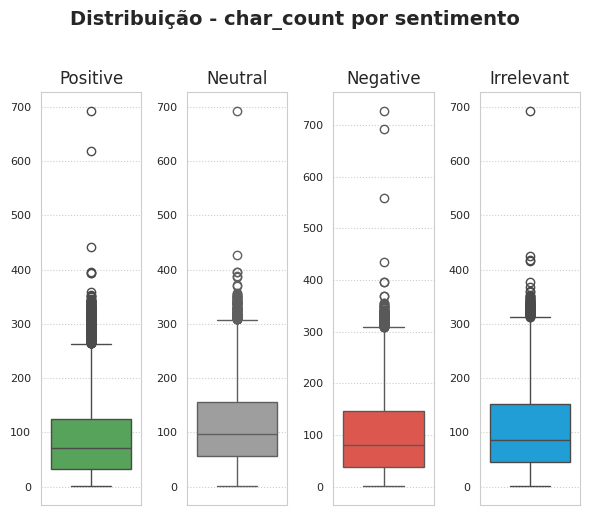

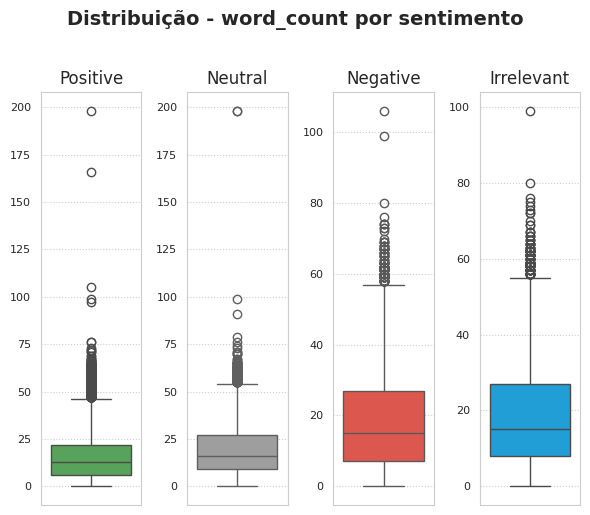

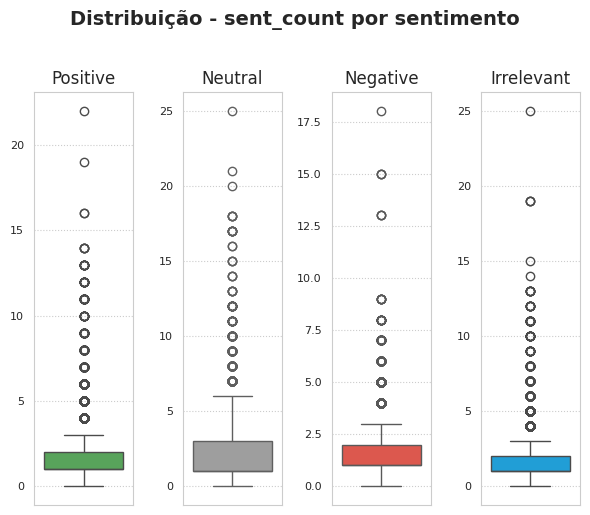

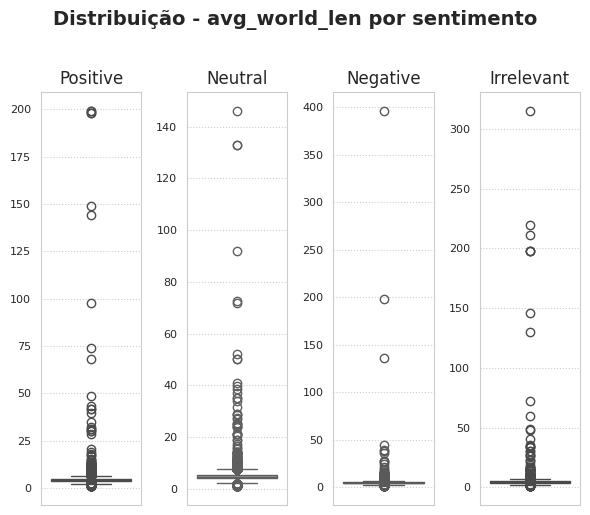

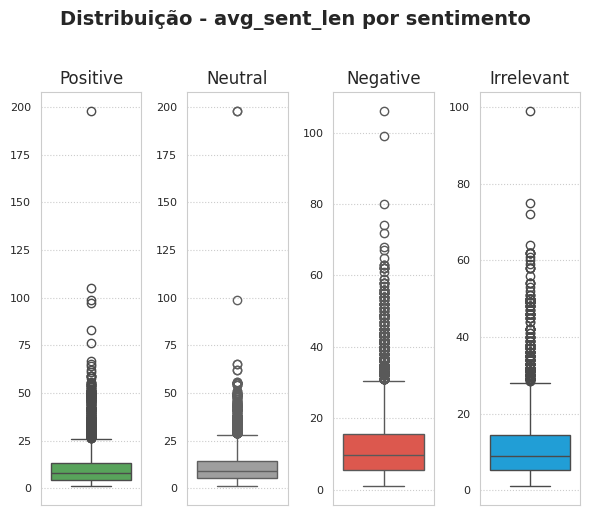

In [ ]:
#Identificação de ruídos e outliers - boxplot por classe

attributes = ['char_count', 'word_count', 'sent_count', 'avg_world_len', 'avg_sent_len']

for attr in attributes:

  boxplot_chart(df_part1, atributo=attr)

**Anaĺise**

char_count: As instâncias possuem praticamente a mesma distribuição, e limite máximo do caracteres. É possível que tenha sido uma orientação seguida durante a amostragem dos dados.

word_count: Igualmente, as distribuições são semelhantes. As categorias 'Positive' e 'neutral' possuem outliers com 200 palavras, mas, podemos ver que a concentração e posição dos demais ponto de dados são semelhantes.


sent_count: Possuem mesma distribuição, o que é de se esperar, vez que se tratam de textos curtos e informais, escritos, geralmente, sem a observâncias de regras sintáticas.

avg_word_len: Não é possível realizar análise com a presença de outliers severos. Será necessára a realização de limpeza.]

avg_sent_len: A distribuição dos sentimentoss 'Positive' e 'Neutral' é semelhantes em vários aspectos, como contrentação da massa de dados, mediana, e, inclusive os outliers. O mesmo padrão se encontra quando se analisa os sentimentos 'Negative' e 'Irrelevant'. Ao se eliminar os outliers, é provãvel que vejamos a mesma concentração para todos os sentimentos.

In [ ]:
# Eliminando ruídos - word_count = 1
df_total = df_total[df_total['word_count'] != 1]

In [ ]:
# Eliminando char_count = 1
df_total = df_total[df_total['char_count'] > 1]

In [ ]:
# Eliminando outliers - usando zscore - com cálculo separado por classe
# Começando pelo atributo word_count
df_total_outliers_droped = drop_outliers(df_total, atributo='word_count', sentiment_hue = ['Positive', 'Negative', 'Neutral', 'Irrelevant'])

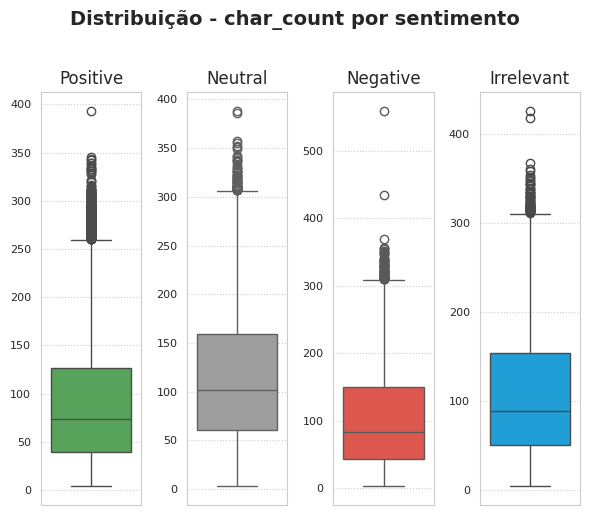

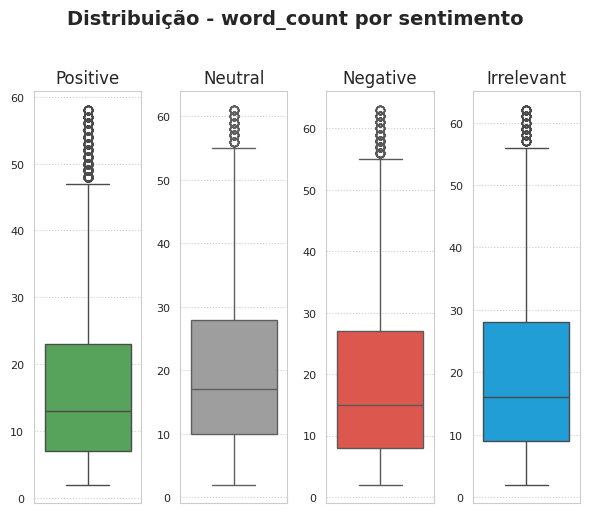

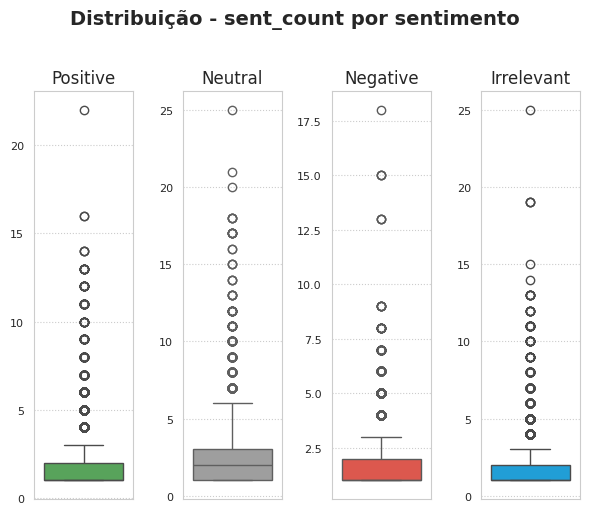

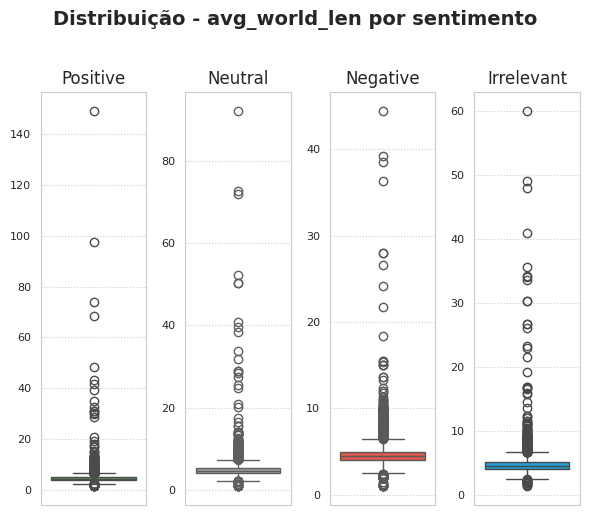

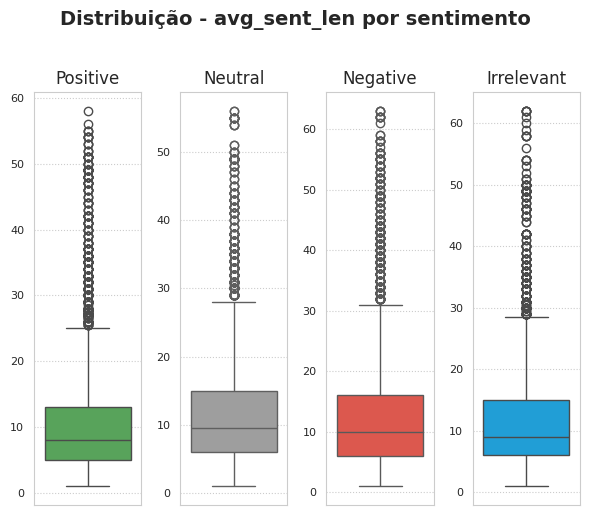

In [ ]:
#Identificação de ruídos e outliers - boxplot por classe

attributes = ['char_count', 'word_count', 'sent_count', 'avg_world_len', 'avg_sent_len']

for attr in attributes:

  boxplot_chart(df_total_outliers_droped, atributo=attr)

Eliminou-se outliers consideravelmente, mas, ainda é visível a presença. A exclusão com base no z-score pode não ser a melhor opção para a exclusão de outliers nestes dados.


Ainda sim, foi possível observar que as estatísticas aprensentam variância (como quartis e mediana) em relação aos sentimentos, o que é excelente para o treinamento do modelo.

Após o término da análise exploratória e descritiva, será tomada a decisão sobre como tratar os outliers.

**Frequência de termos** do corpus


In [ ]:
# Aplicando pipline de limpeza e pré-processamento de texto
df_total['text_processed'] = df_total['text'].map(ProcessaTexto)

In [ ]:
# Observando texto após limpeza
df_total.sample(5)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed
30558,Irrelevant,Super happy to work with @WIHSesports to make ...,83,13,1,5.461538,13.000000,super happy work wihsesport opportunity happen...
30986,Neutral,Watch my video!,15,3,1,4.333333,3.000000,watch video
22009,Positive,Tagged by @ brntwllm.. favorite games I've pla...,319,56,12,4.714286,4.666667,tag brntwllm favorite game ve play one ve enj...
33829,Negative,@ FortniteGame The production of rainwater was...,140,25,2,4.640000,12.500000,fortnitegame production rainwater delay thing...
27202,Positive,Holy oh wow,11,3,1,3.000000,3.000000,holy oh wow


In [ ]:
# Criando corpus
corpus = [word for i in df_total['text_processed'].str.split().values.tolist() for word in i if (word not in stop)]

In [ ]:
# Obtendo os Top 10 elementos do corpus
most_commom_text = Counter(corpus).most_common(10)

In [ ]:
# Capturando dados.
words, count = dict(most_commom_text).keys(), dict(most_commom_text).values()

**Visualizando**

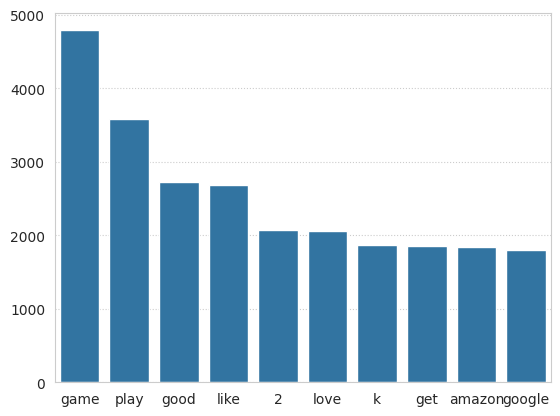

In [ ]:
# Plotando um gráfico de barras

sns.barplot(x = words, y = count);

**Análise**

As palavras mais frequências do corpus denotam que a amosta selecionada pode ter forte relação com jogos e compras on-line.

**Verificação importante.**

Se o objetivo do modelo é ser aplicado de forma geral, deve-se retornar ao processo inicial de amostragem, e garantir que não haja segmentação no tema da na amostra.

A amostragem indicada para populações que contenham segmentação é a amostra extratificada.

No presente caso, tratando-se de dataset púbico, não é possível afirmar que todos os pressupostos foram atendidos.

Assim, o uso generalizado do modelo a ser treinado não é indicado.

**Identificação de linguagem**

De acordo com a documentação do administrador do dataset, os dados foram colhidos no twiiter, rede social de presença mundial. A identificação da linguagem predominante é imprescindível, e, será considerada requisito para utilização do modelo futuro.

Métodos possíveis:

- Confidence score com spaCY
- Com nltk
- Com modelos pré-treinados do hugging face

Utilizaremos o módulo nltk

In [ ]:
# Identificando a linguagem de cada instância

df_total['language'] = df_total['text_processed'].map(language_identify)

In [ ]:
# Visualizando linguagens
df_total['language'].unique()

array(['hinglish', 'catalan', 'albanian', 'english', 'danish', 'basque',
       'german', 'romanian', 'dutch', 'spanish', 'hungarian', 'finnish',
       'italian', 'french', 'azerbaijani', 'indonesian', 'swedish',
       'slovene', 'portuguese', 'norwegian'], dtype=object)

In [ ]:
# Visualizando frequências
pd.DataFrame(df_total['language'].value_counts()).reset_index()

,language,count
0,hinglish,18618
1,albanian,10121
2,english,1794
3,danish,786
4,catalan,575
5,dutch,341
6,german,287
7,french,287
8,romanian,187
9,azerbaijani,85


**Análise**

Entre os 3 mais frequências temos 2 variações de inglês, e albanês.

Primeiramente, é importante destacas que "hinglish" é um termo criado para identificar um fenômeno muito comum em linguagem de rede social, e, em resumo, a mistura de elementos de linguagem do inglês e do hindú (da Índia). Embora não seja reconhecidamente um idioma, é tão difundido que alguns modelos de linguagens, bem como os atuais fremeworks de pré-processamento foram treinados para reconhecê-lo.

Vamos analisar, contudo, a forte presença das instâncias identificadas com a língua albanesa.

In [ ]:
# Visualizando amostra de 'henglish'
df_total[df_total['language'] == 'hinglish'].sample(5)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed,language
2685,Irrelevant,Let’s fucking …,15,3,1,4.333333,3.00,let fucking,hinglish
25980,Positive,My favorite Assassin's Creed moment. Seeing th...,96,12,2,7.083333,6.00,favorite assassins creed moment see fallen pir...,hinglish
12631,Negative,"@ Ronnie2K, where are all my Mamba Edition ext...",207,39,4,4.333333,9.75,ronnie2 k mamba edition extra literally play ...,hinglish
11803,Positive,Let's fucking go @ Flexecution1,31,5,1,5.400000,5.00,let fucking flexecution1,hinglish
23648,Positive,Good to know.,13,3,1,3.666667,3.00,good know,hinglish


In [ ]:
# Visualizando amostra de 'albanian'
df_total[df_total['language'] == 'albanian'].sample(5)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed,language
34992,Positive,Hugely important news this,26,4,1,5.750000,4.0,hugely important news,albanian
19329,Neutral,I just scored the [The Most Horrific Vision of...,70,11,1,5.454545,11.0,score horrific vision stormwind achievement,albanian
26093,Irrelevant,Found this perfect place for Zeus,33,6,1,4.666667,6.0,find perfect place zeus,albanian
8268,Irrelevant,My Favorite Overwatch Event.,29,4,1,6.250000,4.0,favorite overwatch event,albanian
33326,Positive,It's Lit.,9,2,1,4.000000,2.0,lit,albanian


Uma rápida observada na amostra das intâncias identificadas com linguagem 'albanian' permite concluir que o módulo nltk não fez um bom trabalho na identificação da linguagem.

Vamos criar um pipline com spacy, e ver como se sai.

In [ ]:
# Instanciando nova classe para detecção
service = LanguageDetectorService()

In [ ]:
df_total['language_spacy'] = df_total['text_processed'].map(service.return_language)

In [ ]:
# Visualizando linguagens
df_total['language_spacy'].unique()

array(['da', 'nl', 'en', 'sv', 'UNKNOWN', 'ca', 'fi', 'es', 'af', 'no',
       'vi', 'et', 'cy', 'cs', 'so', 'ro', 'it', 'de', 'pt', 'fr', 'hr',
       'tl', 'lv', 'id', 'pl', 'sk', 'sl', 'tr', 'sq', 'lt', 'sw', 'hu'],
      dtype=object)

In [ ]:
# Visualizando frequencias
summary_languages = pd.DataFrame(df_total['language_spacy'].value_counts()).reset_index()

In [ ]:
summary_languages.head()

,language_spacy,count
0,en,25833
1,af,762
2,so,574
3,fr,550
4,nl,537


In [ ]:
np.round(summary_languages[summary_languages['language_spacy'] == 'en']['count'].values / df_total.shape[0] * 100, 2)

array([77.26])

**Análise**

Utilizando o modelo do próprio spacy, temos que 77% das instâncias tiveram a linguagem identificada como inglês.

Vamos visualizar uma amostra, e, caso o match seja correspondente, seguiremos para a conclusão da parte 1 da EDA.

In [ ]:
# Visualizando dados com linguagem identificada pelo spacy
df_total[df_total['language_spacy'] == 'en'].sample(10)

,sentiment,text,char_count,word_count,sent_count,avg_world_len,avg_sent_len,text_processed,language,language_spacy
31894,Positive,zoe is totally not healthy and who does theref...,101,19,1,4.368421,19.000000,zoe totally healthy deserve hate insane nerf,albanian,en
22271,Negative,politicians have ALWAYS accused good players f...,289,40,4,6.250000,10.000000,politician accuse good player suck regardless ...,hinglish,en
4028,Positive,It's Xbox Early Access day! We can't wait to p...,53,10,2,4.400000,5.000000,xbox early access day not wait play,english,en
28578,Negative,"literally toxic bro, left the game when i was ...",141,27,2,4.185185,13.500000,literally toxic bro leave game clear res oh kn...,hinglish,en
31656,Neutral,THIS IS THE HIGHEST COMPLEMENT I HAVE EVER REC...,139,25,2,4.520000,12.500000,highest complement receive thank dude home say...,hinglish,en
1737,Negative,@GearboxOfficial @Borderlands. Am we seeing th...,219,35,7,5.285714,5.142857,gearboxofficial borderlands see correctly reas...,hinglish,en
5104,Irrelevant,Social distancing ways can be sexy!,35,6,1,5.000000,6.000000,social distancing way sexy,hinglish,en
10860,Negative,"I hate this game. EVERY SINGLE YEAR, THEY STAY...",62,11,2,4.727273,5.500000,hate game single year stay tempting people,hinglish,en
32412,Neutral,Is League of Legends toxic? (please participat...,78,12,2,5.583333,6.000000,league legends toxic participate m try prove,hinglish,en
638,Neutral,playing borderlands 3 before 2 was a mistake b...,128,28,2,3.607143,14.000000,play borderland 3 2 mistake bc know die replay...,hinglish,en


Visualizado, portanto, que a identificação está correta.

In [ ]:
# Filtro por linguagem
df_total = df_total[df_total['language_spacy'] == 'en']

In [ ]:
# Presistindo dados
#df_total.to_csv("../output/datasets/data.csv", index = False)

##### Análise exploratória - Part. 1 - **Conclusão**

1 - **Metadados como**:

  1.1. Dimensão do dataset após limpeza;
  
  1.2. Tipo de quantidade de atributos;
  
  1.3. Tema geral sobre as mensagens colhidas (indício)

2 - **Classes** (target- sentimentoss) presentes no dataset;

3 - **Análise estatística e gráfica**, por sentimento, de elementos descritivos como:

  3.1. Frequência de caracteres;
  
  3.2. Frequência de palavras;
  
  3.3. Frequência de sentenças;
  
  3.4. Média de palavras;
  
  3.5. Média de caracteres

4 - **Lingua predominante**.

5 - **Também pudemos averiguar a necessidade de alguns procedimentos prévios como**:

  5.1. Limpeza do texto
  
  5.2. Lematização
  
  5.3. Identificação e eliminação de outliers


A EDA inicial, portanto, foi bastante produtiva.

### **No próimo notebook, EDA - 2 (nível intermediário)**